Некоторый город (или район города, напри- мер, Манхэттен) имеет квадратную клеточную транспортную сеть с n = $20^{2}$ клетками. Считаем, что независимо из каждой вершины в утренние часы пик с постоянной интенсивностью (пуассоновского процесса) $\lambda$ = 1000 чел/час водители выезжают на работу на автомобилях, причем место работы с равной вероятностью находится в любой другой вершине. Маршрут также выбирается случайно и равновероятно из кратчайших (по числу ребер) маршрутов с одинаковым числом ребер. Время в пути по ребру e есть экспоненциальная случайная величина с математическим ожиданием, равным t = max{5, 2 · 10
−2· Ne} мин, где Ne —число автомобилей на ребре e в данный момент времени. 
Требуется найти минимальный процент водителей, предоставляющих информацию о своих скоростях на ребрах, чтобы в произвольный момент времени (здесь предполагается, что к этому моменту времени город уже довольно долго «жил» в описанном выше режиме) не менее чем по r = 90% ребер была текущая информация о загрузке (возможно избыточная, т. е. несколько значений по одному ребру) с вероятностью не менее g = 0,9? Информация считается текущей, если она была
получена менее t = 30 минут назад. Время, потраченное на прохождения перекрестка - 0.5 мин.


In [2]:
import random as rd
import scipy
import os
import numpy as np
import seaborn as sns
import random
import networkx as nx
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt



In [3]:
def p_event(lambda_coef, tau):
    """
    Вероятность хоть одного события
    """
    return 1 - np.exp(-lambda_coef*tau)

def get_edge_time_for_car(edge_index,curr_time):
    """
    Получение индекса текущего момента времени на дискретном интервале временных промежутков, 
    а также расчет времени прохождения текущего ребра
    """
    if curr_time<=TIME_LIMIT:
        time_stamp_index = np.where((TIME[:,0]<=curr_time) & (TIME[:,1]>=curr_time))[0][0]
    else:
        time_stamp_index = partition-1
    
    time_on_vert = np.random.exponential(max(5,(edges_info[time_stamp_index,edge_index,0]) * 0.02))
    
    return time_stamp_index, time_on_vert


def sample_time(lambda_coef):
    """
    Семплирование промежутка между двумя событиями
    """
    return (-1/(lambda_coef)*np.log(np.random.uniform(0,1)))

def init_car_deps(lambda_coef):
    """
    Получение времен выезда для всех машин из конкретной вершины на заданном промежутке
    """
    departments = []
    car_num = 0
    curr_time = 0
    while car_num<number_of_cars:
        curr_time += sample_time(lambda_coef) * 60
        if curr_time >TIME_LIMIT:
            break
        car_num += 1
        departments.append(curr_time)
    return departments


def count_direction(path):
    """
    Вспомогательная функция для перестановки путей до вершин
    """
    left, right, up, down = 0, 0, 0, 0
    for (i,j) in zip(path,path[1:]):
        if i[0]<j[0] and i[1]==j[1]:
            right += 1
        if i[1]<j[1] and i[0]==j[0]:
            up += 1
        if i[0]>j[0] and i[1]==j[1]:
            left += 1
        if i[1]>j[1] and i[0]==j[0]:
            down += 1
    return ['r'] * right + ['u'] * up + ['d'] * down + ['l'] * left


def create_path(start_point, directions):
    """
    Получение случайного пути (кратчайшего) до конкретной вершины
    """
    np.random.shuffle(directions)
    path = [start_point]
    curr_point = start_point
    for d in directions:
        if d=='r':
            path.append((curr_point[0]+1,curr_point[1]))
        if d=='u':
            path.append((curr_point[0],curr_point[1]+1))
        if d=='l':
            path.append((curr_point[0]-1,curr_point[1]))
        if d=='d':
            path.append((curr_point[0],curr_point[1]-1))
        curr_point = path[-1]
    return path

### Зададим параметры системы

In [4]:


# Граф
G = nx.grid_2d_graph(20,20)
# Количество отрезков на которые поделится временная ось
partition = 720
# Интенсивность пуассоновского потока
lambda_coef = 1000
# Время жизни системы
TIME_LIMIT = 360

graph_edges = list(G.edges)
num_edges = len(graph_edges)
grid_size = TIME_LIMIT/(partition)
vertices_list = list(G.nodes)
# Массив временных отрезков 
arr = np.round(np.linspace(0.0,TIME_LIMIT,partition), 2)
TIME = np.array([[arr[i],arr[j]] for i,j in zip(range(len(arr)-1),range(1,len(arr)))])


cars_to_stock = 15




number_of_cars = int(lambda_coef*TIME_LIMIT/60)








 Для каждой вершины смоделируем интервалы для между двумя событиями (выезд машины) с помощью семлирования пуассоновской случайной величины: \
 Вероятность появления N событий за время $\tau:$ 
  ### $  P_N = \frac{(\lambda\tau)^N e^{-\lambda \tau}}{N!}  $
  Вероятность, что хотя бы одно событие произойдет: 
 ### $P_1 = 1 - P_0 = 1 - e^{-\lambda \tau}$
 Посмотрим, как ведет себя данная функция:

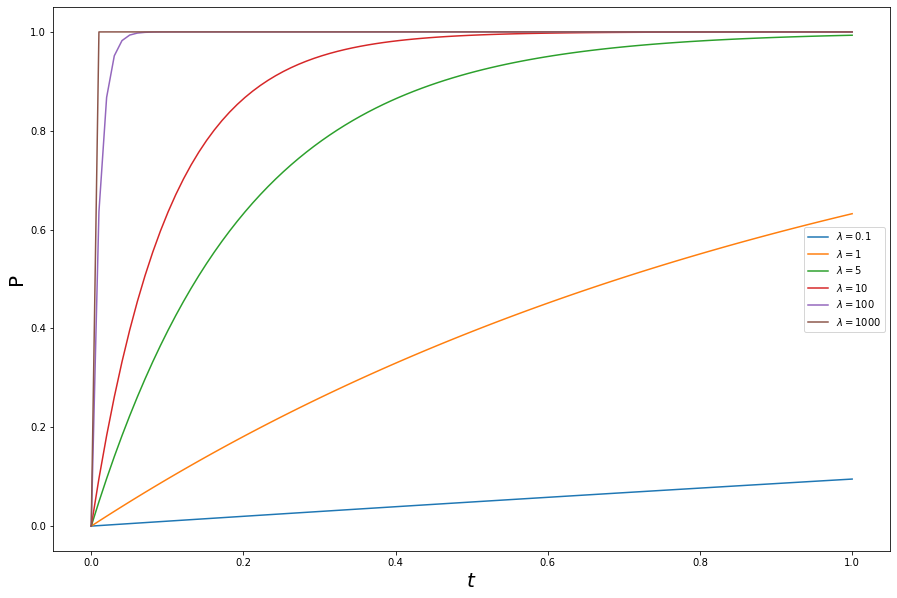

In [55]:

tau = np.linspace(0,1,100)
plt.figure(figsize=(15,10))
for lambda_ in [0.1,1,5,10,100,1000]:
    plt.plot(tau,p_event(lambda_, tau), label = f'$\lambda = ${lambda_}')
    plt.legend()
    plt.xlabel('$t$',fontsize = 20)
    plt.ylabel('P',fontsize = 20)

Тогда процедура семлирования: 
## $\tau = -\frac{Ln(\epsilon)}{\lambda}, \epsilon \sim \mathbf{Uniform}(0,1)$ 

Таким образом для каждой вершины мы имеем набор времен отправлений водителей. Также для каждого водителя случайно выбирается точка на графе города и случайно выбирается маршрут (из кратчайших по числу ребер). Время на ребре выбирается случайно из:
### $t \sim Exp(\frac{1}{max(5,10^{-2}N_e})$
где $N_e$ - число машин на ребре $\mathbf{e}$ в данный момент времени 

Смоделируем  систему и запишем статистику: 

In [11]:
path_examples = []
for exp in range(10):
    big_edges_list = np.zeros((partition,len(graph_edges),cars_to_stock)) 
    edges_info = np.zeros((partition,len(graph_edges),1))
    for point_number, start_point in tqdm(enumerate(vertices_list)): #[(0,1)]
        
        dep_times = init_car_deps(lambda_coef)

        for car in range(len(dep_times)):
            curr_time_for_car = dep_times[car]
            if curr_time_for_car>=TIME_LIMIT:
                break
            end_point = start_point
            while end_point == start_point:
                end_point = (np.random.randint(0,20), np.random.randint(0,20))
            short_path =  (list(nx.shortest_path(G, source=start_point, target=end_point)))
            path = (create_path(start_point, count_direction(short_path)))
            path_examples.append(path)
            for from_ver, to_ver in zip(path,path[1:]):
                    curr_edge = graph_edges.index((to_ver,from_ver)) if (to_ver,from_ver) in graph_edges else graph_edges.index((from_ver,to_ver))
                    time_stamp_index, time_for_edge = get_edge_time_for_car(curr_edge, curr_time_for_car)
                    end_edge_time_index = time_stamp_index + int(time_for_edge//grid_size) + 1

                    if (to_ver!=end_point) and (end_edge_time_index < len(TIME)):
                        edges_info[time_stamp_index:end_edge_time_index,curr_edge,0] += 1
                    
                        for stamp in range(time_stamp_index,end_edge_time_index):
                            for car_index in range(big_edges_list.shape[2]):
                                if (big_edges_list[stamp,curr_edge,car_index] == 0) and (car+point_number*int(lambda_coef*curr_time_for_car/60) not in big_edges_list[stamp,curr_edge,:]):
                                    big_edges_list[stamp,curr_edge, car_index] = car+point_number*int(lambda_coef*curr_time_for_car/60)
                        curr_time_for_car += time_for_edge + 0.5
                        continue

                    elif (to_ver==end_point) and end_edge_time_index<len(TIME):
                        edges_info[time_stamp_index:end_edge_time_index,curr_edge,0] += 1

                        
                        for stamp in range(time_stamp_index,end_edge_time_index):
                            for car_index in range(big_edges_list.shape[2]):
                                if (big_edges_list[stamp,curr_edge,car_index] == 0) and (car+point_number*int(lambda_coef*curr_time_for_car/60) not in big_edges_list[stamp,curr_edge,:]):
                                    big_edges_list[stamp,curr_edge, car_index] = car+point_number*int(lambda_coef*curr_time_for_car/60)


                        curr_time_for_car += time_for_edge
                        break
                    elif end_edge_time_index>=len(TIME):
                        end_edge_time_index = len(TIME) - 1
                        edges_info[time_stamp_index:end_edge_time_index,curr_edge,0] += 1
                    
                        for stamp in range(time_stamp_index,end_edge_time_index):
                            for car_index in range(big_edges_list.shape[2]):
                                if (big_edges_list[stamp,curr_edge,car_index] == 0) and (car+point_number*int(lambda_coef*curr_time_for_car/60) not in big_edges_list[stamp,curr_edge,:]):
                                    big_edges_list[stamp,curr_edge, car_index] = car+point_number*int(lambda_coef*curr_time_for_car/60)

                        break
                        
                    print ("ALERT")

                    
                    
#     np.save(f'transport_calcs/big_edges_list_{exp}.npy',big_edges_list)
#     np.save(f'transport_calcs/edges_info_{exp}.npy',edges_info)  

1it [00:51, 51.97s/it]


#### Анимация

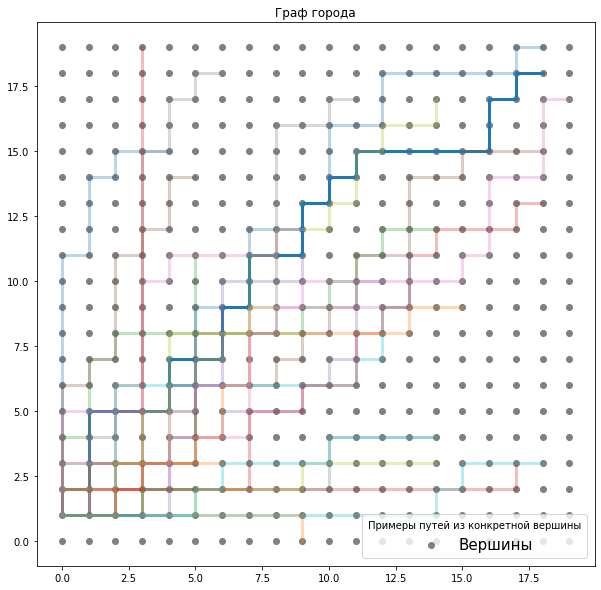

In [38]:

all_positons = []
for path in path_examples[:30]:
    
    x_pos = []
    y_pos = []
    for (cur_x, cur_y) in path:
        plt.figure(figsize=(10,10))
        x_pos.append(cur_x)
        y_pos.append(cur_y)
        plt.scatter(np.array(vertices_list)[:,0],np.array(vertices_list)[:,1], c ='grey', label = 'Вершины')
        plt.legend(title ='Примеры путей из конкретной вершины',fontsize = 15)
        plt.title('Граф города')
        plt.plot(x_pos,y_pos,linewidth=3)
        # plt.pause(0.005)
        for x_p,y_p in all_positons:
            plt.plot(x_p,y_p,linewidth=3, alpha=0.3)
        clear_output(wait=True)
        plt.show()
    all_positons.append([x_pos,y_pos])
    


In [56]:
all_big_edges = []
all_edges_info = []
dir0 = 'transport_calcs'
for m,filename0 in enumerate(os.listdir(dir0)):
        if ('big_edges_list' in str(filename0)):
            listdir1 =(dir0 +'\\'+str(filename0))
            with open(os.path.join(listdir1), 'r') as f:
                all_big_edges.append(np.load(listdir1))
                
        if ('edges_info' in str(filename0)):
            listdir1 =(dir0 +'\\'+str(filename0))
            with open(os.path.join(listdir1), 'r') as f:
                all_edges_info.append(np.load(listdir1))



Получили информацию для числа водителей на каждом ребре во все моменты времени. Также будем хранить массив фиксированного размера уже проиндексированных машин. Далее построим график их числа в произвольный момент времени t (45мин - 360 минут). Где число в каждый момент времени считается следующим образом: \
Проходимся по случайным перестановкам ребер, записывая индекс машины в соответствии с следующим правилами:
* Никаких машин за последние 30 минут к ребру не приписано и ни одна из них не "была замечена" на других ребрах за тот же интервал - записываем новый индекс машины в соответствии ребру
* Если на ребре за последние 30 минут была хоть одна машина, которая "была замечена" на каких-нибудь ребрах - записываем индекс этой машины в соответствии ребру 
* Продолжаем, пока по 90% ребер из перестановки не будет получена информация о водителе (за последние 30 минут) \


Таким образом получаем словарик {ребро:индекс машины}. Возьмем из него все уникальные значения (индексы машин) и усредним по всем перестановкам. Полученное число запишем как такое кол-во водителей, знание о скоростях которых даст информацию не менее чем по 90% ребер в данный момент времени.

In [33]:
start_time_point = int(30//grid_size) + 30

In [ ]:
iter_ = 0
for big_edges_list,edges_info in zip(all_big_edges,all_edges_info):
    print(iter_)
    edge_dict = {edg: -1 for (edg) in range(num_edges)}
    
    results = []
    for pickpoint in tqdm(range(int(30//grid_size) + 30,partition)):
        unique_drivers_for_subsets = []
        for num_subsets_of_edges in range(10):
            
            edge_dict = {edg: -1 for (edg) in range(num_edges)}
            edge_subset = np.arange(num_edges)
            np.random.shuffle(edge_subset)
            for edge in edge_subset:
                if list(edge_dict.values()).count(-1)<=760*0.1:
                    break

                flag = 0

                for car in np.unique(big_edges_list[pickpoint-int(30//grid_size):pickpoint,edge,:].astype(int)):
                    if flag==1:
                        break
                    if car in edge_dict.values():
                            edge_dict[edge] = car
                            flag = 1
                            break
                for car in np.unique(big_edges_list[pickpoint-int(30//grid_size):pickpoint,edge,:].astype(int)):
                        if flag==1:
                            break
                        if (edge_dict[edge] == -1): 
                            edge_dict[edge] = car
                            flag = 1
                            break
            unique_drivers = set()
            for val in edge_dict.values():
                    unique_drivers.add(val)
            
            unique_drivers_for_subsets.append(len(unique_drivers))
    
    
    
        results.append([pickpoint*60/TIME_LIMIT, np.mean(unique_drivers_for_subsets)])
    results = np.array(results)
    plt.plot(results[:,0], results[:,1], label = "Кол-во водителей" )
    plt.legend()
    plt.show()
    np.save(f'drivers_results_{iter_}.npy',results)
    iter_ += 1

In [61]:
results = []
for m,filename0 in enumerate(os.listdir(dir0)):
        if ('drivers_results_' in str(filename0)):
            listdir1 =(dir0 +'\\'+str(filename0))
            with open(os.path.join(listdir1), 'r') as f:
                results.append(np.load(listdir1))

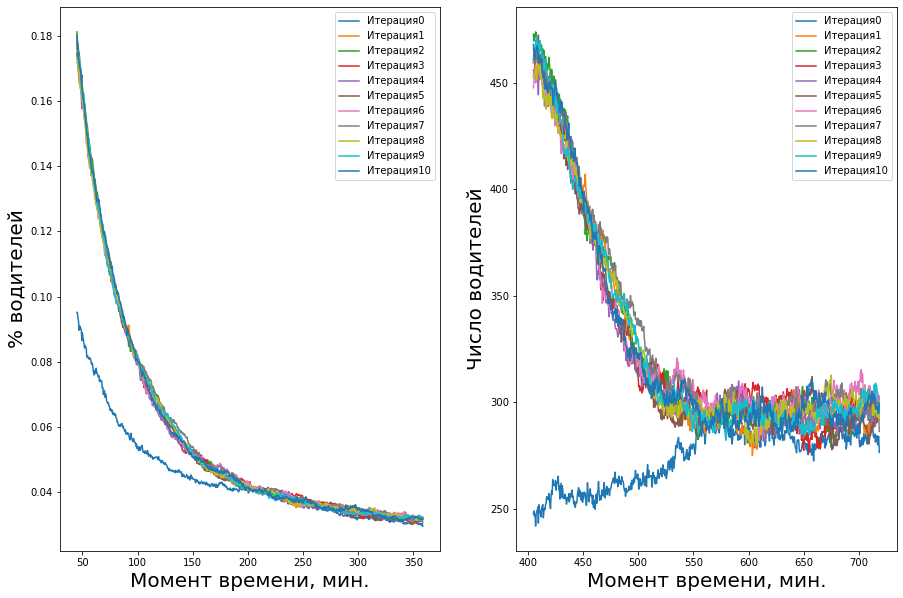

In [69]:
fig, (ax,ax2) = plt.subplots(1,2,figsize=(15,10))
# ax2 = ax.twinx()
for i in range(len(results)):
    ax.plot(results[i][:,0][:-2]*TIME_LIMIT/60/2,results[i][:,1][:-2]/np.sum(all_edges_info[i][start_time_point:,:,0], axis = 1)[:-2]*100, 
             label = f'Итерация{i}') 
    ax2.plot(360+results[i][:,0][:-2]*TIME_LIMIT/60/2,results[i][:,1][:-2],label = f'Итерация{i}')
    ax.legend()
    ax2.legend()
    ax.set_xlabel('Момент времени, мин.',fontsize = 20)
    ax2.set_xlabel('Момент времени, мин.',fontsize = 20)
    ax.set_ylabel('% водителей',fontsize = 20)
    ax2.set_ylabel('Число водителей',fontsize = 20)

plt.show()

Получаем, что с некоторого момента времени, число водителей выходит на плато и минимальное число водителей $\approx$ 300